# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year].tsv``, ``positive_validation_after_{year}_pahse_4.tsv``, ``negative_prediction_after_{year}_phase_4.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [2]:
target_year = 2010
mid_year = 2011
num_years_later = 9

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")

embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 195088 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2010.npy and ../data/embeddings_final/words_SG_upto2010.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-2.641621,3.124869,-4.353377,-2.018315,1.823348,-4.975201,-4.787686,2.649930,-2.948251,-0.916163,...,-1.869853,-3.522519,2.618166,-4.450459,-3.961528,-2.892118,-5.928490,0.367299,-4.532290,2.421597
patient,-3.817505,2.731132,-3.133406,-3.360924,3.251447,-3.779796,-4.411118,2.816041,-5.475833,-2.382731,...,-1.941187,-5.431289,2.350188,-5.862311,-3.625207,-4.146669,-4.293906,0.900865,-4.954704,3.698488
meshd009369,-2.000293,2.692290,-3.906482,-2.403826,2.087734,-4.683461,-4.715221,3.363425,-3.719787,-1.557153,...,-1.572250,-5.367291,2.859295,-5.173111,-5.736109,-3.077639,-3.752953,0.597677,-3.388928,4.321077
study,-3.286283,2.197396,-3.055143,-3.488384,1.583849,-3.476388,-4.572982,2.568147,-4.655032,-2.002333,...,-1.750167,-4.790527,2.999226,-5.209653,-4.173866,-6.466439,-4.163732,0.406401,-3.173547,2.894467
1,-1.973735,2.599354,-4.169664,-2.950947,1.642805,-4.464195,-4.122997,3.285105,-3.085233,-2.332377,...,-1.851673,-4.228116,2.728837,-6.189056,-3.837825,-5.297565,-4.471994,0.961740,-3.943491,3.863080
0,-2.586123,2.689704,-4.212170,-3.771425,1.231912,-4.831149,-4.203139,2.516318,-4.278717,-0.870984,...,-1.646774,-3.917393,3.147377,-6.403146,-3.208885,-4.337939,-5.274619,1.493022,-4.262381,3.811445
case,-2.901989,3.094942,-2.662760,-2.999618,3.339018,-4.174236,-3.733308,3.043080,-5.015265,-2.009101,...,-1.629706,-5.274364,2.490766,-6.020258,-4.223149,-5.065413,-4.717482,1.171679,-4.160813,3.578443
2,-1.995389,2.613357,-4.465601,-3.374403,1.476374,-3.963554,-4.275064,3.415569,-3.165894,-2.673264,...,-1.870650,-4.507325,2.781323,-6.268209,-3.587891,-5.258845,-4.164574,0.931996,-4.031983,3.908941
use,-2.350996,2.471157,-3.943660,-4.285838,1.903959,-3.824636,-5.363203,3.795658,-3.144410,-2.605247,...,-1.496192,-3.672382,3.161894,-3.771332,-5.287291,-5.904677,-6.007619,0.785128,-5.524373,3.306188
treatment,-4.137800,2.313303,-4.491300,-4.538378,2.906991,-3.536086,-5.214668,3.688766,-3.349134,-2.446090,...,-1.661259,-3.453831,2.958672,-6.402697,-2.986871,-6.025044,-3.379093,0.627732,-5.395659,5.521724


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  195088


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples =  "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd015179,ncbigene1956
1,meshd009362,ncbigene1956
2,meshd016609,ncbigene1956
3,meshd008113,ncbigene1956
4,meshd002289,ncbigene1956


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

161 positive examples
195088 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 132 kinase-cancer difference vectors
[INFO]	Initial data: 161 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 0 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd015179,-1.758768,0.821506,-0.218957,-0.418908,1.173821,2.282200,-0.896008,0.869499,-0.596625,-1.125477,...,0.244606,-0.978184,-0.364866,-0.861954,2.721985,0.355013,-1.774969,0.447741,0.221942,0.967503
ncbigene1956-meshd009362,-0.488660,-0.127344,1.152679,-1.458963,0.629901,1.370382,-0.432642,-0.060593,-0.768857,-0.831967,...,-0.106943,-2.545844,1.020391,2.764358,0.198052,-1.228320,-2.482996,0.121853,-0.002106,-0.983001
ncbigene1956-meshd016609,1.205292,0.113798,-1.177771,-1.224409,-0.320766,0.655336,-1.157197,1.443528,-1.263317,-1.750137,...,0.342476,-3.346388,-0.123938,-0.298214,0.739539,-0.900963,-2.440659,1.079363,0.378580,-1.017632
ncbigene1956-meshd008113,0.243748,0.850496,-0.247731,-1.412440,-1.462184,3.085130,-1.012596,2.120200,-1.968772,-2.174910,...,0.080879,-2.727978,0.043658,-0.467317,0.111648,0.602614,-2.497726,0.504189,-1.959718,0.611904
ncbigene1956-meshd002289,-0.197365,0.567358,-0.211547,0.391760,0.885465,2.867372,0.110631,1.182542,1.366991,-1.176261,...,0.283839,-0.278417,0.089316,0.738022,1.080370,-0.954275,-1.885794,0.135279,-1.811702,-0.210935


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

132 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd006394,ncbigene3643
1,meshd001749,ncbigene388228
2,meshd014328,ncbigene11329
3,meshd008303,ncbigene8621
4,meshd018333,ncbigene659


In [12]:
print("%d negative examples" % len(negative_df))

1350 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 1144 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 39 gene ids
[INFO]	Could not identify 46 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene3643-meshd006394,0.495955,-0.084904,-1.561551,-2.253521,-0.831221,1.346417,-0.559338,-0.402603,-1.472536,-1.086543,...,-0.126340,0.433736,0.522292,1.307583,-0.750225,-0.619045,-2.106587,0.748317,-2.178948,-0.294259
ncbigene388228-meshd001749,1.796216,-1.839824,3.215138,2.464205,0.619493,3.954749,3.967917,-4.216804,5.716997,2.442918,...,1.649802,4.838514,-3.160438,4.951314,4.174631,3.511041,4.033557,-0.893663,2.427518,-2.255340
ncbigene11329-meshd014328,1.629145,-1.301344,0.416075,-1.232872,-0.933085,-0.017018,-0.281929,-1.077991,2.104239,1.600130,...,0.995776,1.217893,-0.892356,2.262267,3.327279,0.509271,0.984261,-0.804959,1.292967,-0.451439
ncbigene8621-meshd008303,1.671388,-0.719340,1.265435,-0.051755,-0.569608,1.123451,0.323100,-0.498403,1.132227,0.747383,...,0.948202,1.296361,-0.604687,1.546020,0.953608,0.421144,0.665478,-1.403116,0.410443,0.728588
ncbigene659-meshd018333,-0.198712,0.731131,-2.321664,-0.974276,0.747983,-0.889937,-0.702628,0.074381,-1.598525,-1.092208,...,-1.373147,-0.937511,1.319035,-1.165915,-0.724994,-0.721140,-1.097024,0.160577,-0.702646,0.924113


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=132) and negative (n=1144) to the combined dataframe (1276)


In [16]:
X_train.values

array([[-1.7587682 ,  0.8215058 , -0.21895671, ...,  0.44774115,
         0.22194195,  0.9675026 ],
       [-0.4886601 , -0.12734413,  1.1526792 , ...,  0.12185264,
        -0.00210643, -0.9830005 ],
       [ 1.2052921 ,  0.11379838, -1.1777706 , ...,  1.0793628 ,
         0.37857962, -1.0176322 ],
       ...,
       [ 1.9854279 ,  0.28195786, -0.8331654 , ..., -1.3725777 ,
        -1.6945176 ,  1.9920008 ],
       [ 1.154165  , -1.2822586 ,  0.7427902 , ..., -0.9572005 ,
         1.8503935 , -0.86274767],
       [ 0.31370354, -0.38702297,  0.5212686 , ..., -0.5593511 ,
        -0.41032934, -0.37986064]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6107938  0.05029974 0.03479319]


Text(0, 0.5, 'PC 2 (5.03%)')

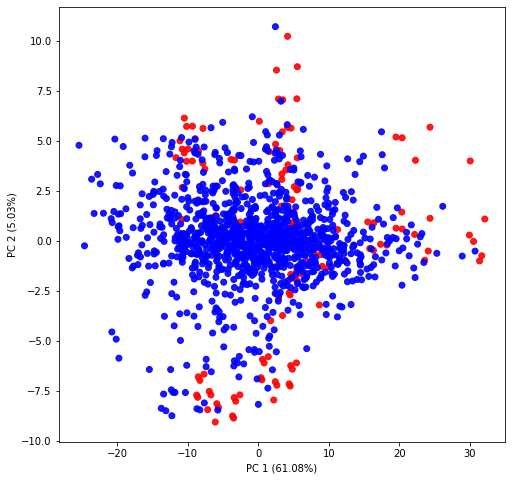

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1276 samples in 0.001s...
[t-SNE] Computed neighbors for 1276 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1276
[t-SNE] Computed conditional probabilities for sample 1276 / 1276
[t-SNE] Mean sigma: 1.225075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.036469
[t-SNE] KL divergence after 300 iterations: 0.738429
t-SNE done! Time elapsed: 5.188082933425903 seconds


Text(0, 0.5, 'tsne-2d-two')

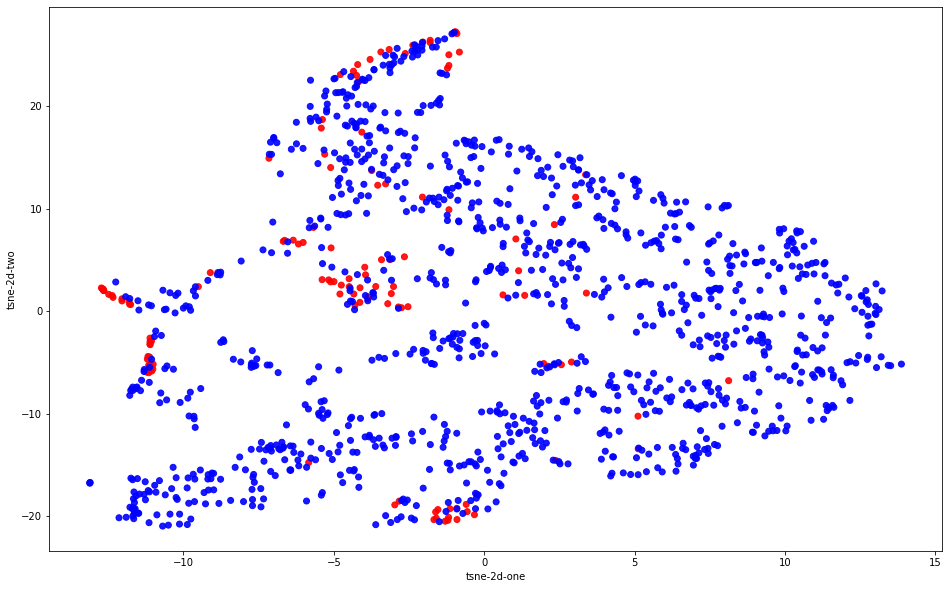

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (1276, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 132, number of negative examples: 1144, Y_train.shape: (1276,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}_target_{}_phase4.tsv".format(num_years_later, mid_year,target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd055752,ncbigene9748
1,meshd016609,ncbigene3480
2,meshd005729,ncbigene673
3,meshd009362,ncbigene3480
4,meshd009362,ncbigene6098


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 117 kinase-cancer difference vectors
[INFO]	Initial data: 123 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 2 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene9748-meshd055752,1.866853,-1.212451,1.721893,0.244282,-0.650136,2.408121,0.959387,-0.478530,2.866008,1.778167,...,0.974777,3.033668,-1.078223,1.745044,2.092914,0.371243,0.664180,-0.956067,0.157970,-0.005643
ncbigene3480-meshd016609,1.076632,0.137506,-1.637602,-0.996579,-0.418967,1.004462,-0.290174,0.134134,0.553663,-0.768469,...,0.168729,-0.582129,-0.106336,-1.739985,0.013113,-1.437330,-2.435177,0.701856,-0.247680,-0.755311
ncbigene673-meshd005729,1.730928,0.223459,0.910663,-3.211418,0.600800,0.467505,-1.058480,1.853049,-1.312851,-1.755743,...,-0.384012,-0.579553,0.995400,-0.460378,1.383815,-0.817785,-1.246976,-1.787122,0.544922,-0.698474
ncbigene3480-meshd009362,-0.617320,-0.103636,0.692848,-1.231133,0.531699,1.719507,0.434382,-1.369987,1.048123,0.149701,...,-0.280690,0.218415,1.037993,1.322588,-0.528373,-1.764687,-2.477514,-0.255654,-0.628366,-0.720679
ncbigene6098-meshd009362,0.033919,-1.505551,2.886956,0.791126,-0.170069,2.476337,1.891497,-2.367394,2.303382,0.992907,...,0.688199,1.212529,-0.039798,4.857274,1.434072,0.505965,1.041707,-0.653197,1.391905,-1.400316


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_upto_{}.tsv".format(target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd018290,ncbigene9943
1,meshd005266,ncbigene5562
2,meshd002583,ncbigene8767
3,meshd000077779,ncbigene7273
4,meshd015173,ncbigene818


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 1161 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 40 gene ids
[INFO]	Could not identify 43 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene9943-meshd018290,1.235626,-0.795970,0.870901,1.300752,-0.040963,0.599176,1.480124,-3.561952,3.428815,1.543086,...,1.452729,4.005970,-2.143205,3.649502,2.293380,1.688380,2.297626,-0.156362,1.264854,-4.358292
ncbigene5562-meshd005266,1.006594,-0.377373,-1.419624,-2.650101,0.297684,-0.829208,-0.246748,0.573084,-1.407018,-0.673322,...,-0.322791,0.209225,1.108299,-1.367585,-1.326891,-1.250765,-0.555206,-0.929186,-0.293384,1.116718
ncbigene8767-meshd002583,1.526387,-0.511185,0.225037,0.072019,1.665189,1.742303,0.618375,-2.049759,2.652229,1.641049,...,0.648799,2.860165,-1.603833,0.697969,3.065827,-0.136885,2.514588,-1.100622,0.455111,-3.389084
ncbigene7273-meshd000077779,0.214535,-0.543837,-0.563923,-1.537841,-2.149791,2.007519,0.148709,0.772390,1.114138,-0.834872,...,0.235407,-0.874100,0.001012,1.547426,-0.899998,0.025702,-1.283360,0.455677,0.160294,0.110312
ncbigene818-meshd015173,0.692341,0.189743,-0.695398,-2.307807,-0.853580,0.362163,-0.151078,1.780090,-0.457643,0.051218,...,-0.126757,-0.178998,0.564686,-0.925722,-1.618138,-0.244022,-0.845961,-0.176466,-0.685917,-0.236094


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-target-{}-phase4.pkl".format(num_years_later, mid_year,target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path = "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}.pkl".format(target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)